In [1]:
import geopandas as gpd
import xarray as xr
import pandas as pd

from metloom.pointdata import SnotelPointData, USGSPointData, MesowestPointData
import datetime as dt
import matplotlib.pyplot as plt
from metloom.variables import SnotelVariables, SensorDescription
import shapely
import contextily as cx

/tmp/ipykernel_7722/3023987552.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
ucrb_hcdn_stations = gpd.read_file('./ucrb_hcdn_stations.json')
ucrb_hcdn_stations['geometry'] = gpd.GeoSeries(ucrb_hcdn_stations['geometry']).map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))
ucrb_hcdn_stations = ucrb_hcdn_stations.set_crs(epsg='4326')

In [3]:
ucrb_hcdn_stations_rpj = ucrb_hcdn_stations.to_crs(epsg='32613')

In [4]:
ucrb_hcdn_basins = gpd.read_file('./ucrb_hcdn_polygons.json')
ucrb_hcdn_basins_rpj = ucrb_hcdn_basins.to_crs(epsg='32613')


In [5]:
AWDB_API_DOMAIN = "https://api.snowdata.info"
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"
msnt_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=MSNT&format=geojson"
# Get the data and rename everything to match the snow ex columns
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)
gdf_sntl = gdf_sntl.to_crs(epsg='32613')

In [97]:
nearest_sntl = {}
for basin in ucrb_hcdn_basins:
    # calculate distances between br_geom and the points
    # {index: distance, index: distance, ...} / r[0]: index, r[1]: row in DataFrame
    dist = {r[0]: r[1].geometry.distance(basin.geometry.centroid) for r in gdf_sntl[gdf_sntl['site_id'].str.contains('CO')].iterrows()}

    # get the nearest point index
    index = min(dist, key=dist.get)

    #get the point by index
    nearest_point = gdf_sntl[gdf_sntl['site_id'].str.contains('CO')].loc[index]['site_id']
    nearest_sntl[basin['GAGE_ID']] = nearest_point


AttributeError: 'str' object has no attribute 'geometry'

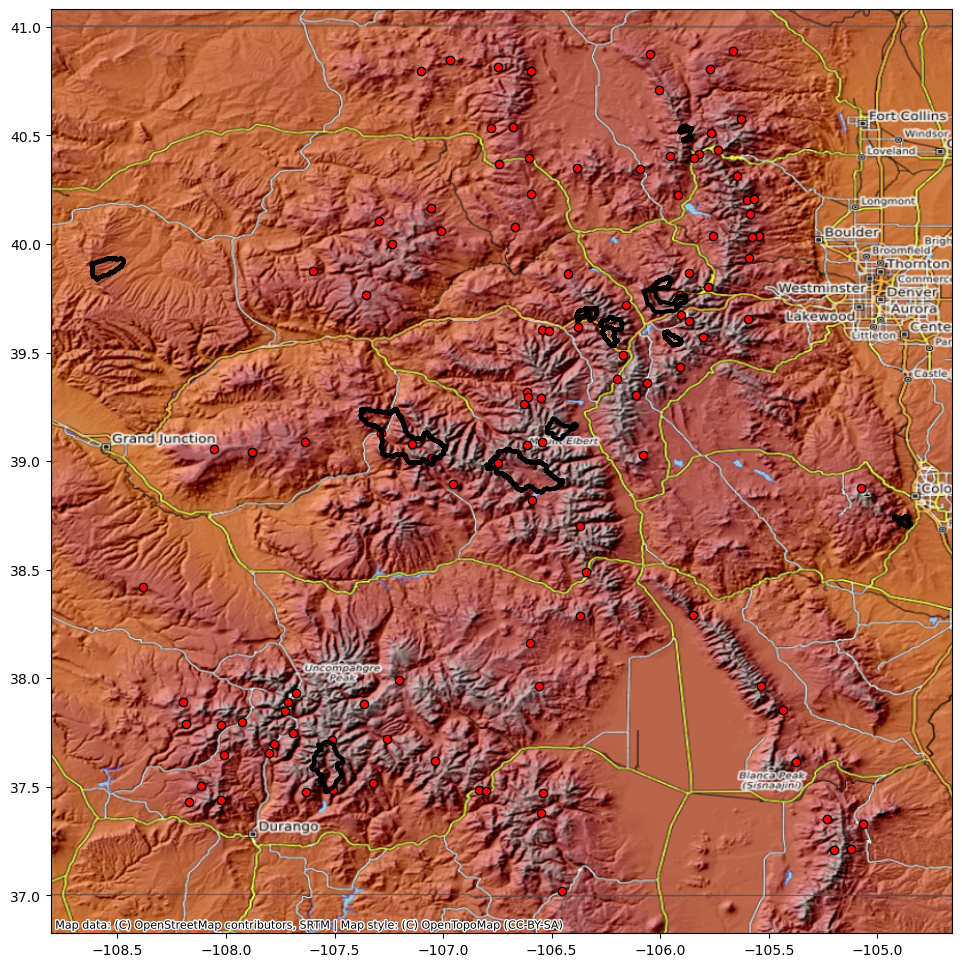

In [88]:

ax=ucrb_hcdn_basins.boundary.plot(color='k', linewidth=3, label='HCDN Boundaries', figsize=(12,12),edgecolor='k')

#Add in hospitals as points
gdf_sntl[gdf_sntl['site_id'].isin(sntl_in_hcdn.keys())].plot(c="r", alpha=1, ec='k', label='SNOTEL Sites', ax=ax)
#Now adding in the basemap imagery
cx.add_basemap(ax, crs=ucrb_hcdn_basins.crs.to_string(), source=cx.providers.OpenTopoMap)
